In [1]:
import io
from functools import reduce
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm
from scipy.ndimage import zoom
from scipy.interpolate import griddata
from PIL import Image
import cv2
from tqdm import tqdm
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import seaborn as sns
import matplotlib.colors as mcolors
import pickle

In [2]:
#download the summer dataframes for the timespan from 2009 - 2019 for all local (earth) time zones
#the download files consist of 96 dataframes each covering the daily measurements of a 15min interval

lunar_temp_data_collection = []

for i in tqdm(range(1, 40), desc='Downloading data'):

    url = f'https://pds-geosciences.wustl.edu/lro/urn-nasa-pds-lro_diviner_derived1/data_derived_pcp/diurnal/ltim/poln/pcp_avg_tbol_poln_sum_ltim{i:02d}_240.tab'

    # Load the data frame from the URL using requests
    response = requests.get(url, verify=True)

    response.raise_for_status()  # raise an exception if there was an error


    # Load the data frame from the response content
    current_df = pd.read_csv(io.StringIO(response.content.decode()))

    #delete unneccesary rows of current_df to optimize storage requirements
    current_df.drop(['        x', '         y'], axis=1, inplace=True)
    current_df[['        clon', '       clat', '       tbol']] = current_df[['        clon', '       clat', '       tbol']].astype(np.float32)


    current_df_memory_usage = current_df.memory_usage().sum() 
    print(f"Memory usage of {i}th dataframe: {current_df_memory_usage / 1024 / 1024:.2f} MB")

    lunar_temp_data_collection.append(current_df)

Memory usage of 1th dataframe: 50.86 MB


Memory usage of 2th dataframe: 52.08 MB


Memory usage of 3th dataframe: 48.68 MB


Memory usage of 4th dataframe: 50.35 MB


Memory usage of 5th dataframe: 49.43 MB


Memory usage of 6th dataframe: 49.60 MB


Memory usage of 7th dataframe: 47.63 MB


Memory usage of 8th dataframe: 50.52 MB


Memory usage of 9th dataframe: 50.09 MB


In [ ]:
#safe lunar_temp_data_collection to a file

with open('../results/lunar_temp_data_collection', 'wb') as file:
    pickle.dump(lunar_temp_data_collection, file)


In [ ]:
#open lunar_temp_data_collection

with open('../results/lunar_temp_data_collection', 'rb') as file:
    lunar_temp_data_collection = pickle.load(file)

## Across All Local Time Intervals

In [ ]:
#set constraint ranges in Kelvin
temp_min = 243
temp_max = 303
temp_avg = 283

#set parameters for analysis & visualization
coordinate_decimals = 3
heat_map_bins = 2000

#### Analysis

In [ ]:
#Perform groupby across all local times
#group measurements by unique combinations of longitutde and latitude and calculate min, max and avg for every position

#append all dataframes for all local times
lunar_temp_data_total = pd.concat(lunar_temp_data_collection)

#round coordinates of measurements to derive representetive data for specific regions 
lunar_temp_data_total['        clon'] = lunar_temp_data_total['        clon'].round(decimals = coordinate_decimals)
lunar_temp_data_total['       clat'] = lunar_temp_data_total['       clat'].round(decimals = coordinate_decimals)

# Select 30% of the data randomly to reduce data complexity
sample_fraction = 0.3
lunar_temp_sample = lunar_temp_data_total.sample(frac=sample_fraction)


#perfom groupby to determine min, max and avergage temperature brightness values 
lunar_temp_data_analysed = lunar_temp_data_total.groupby(['        clon', '       clat']).agg({'       tbol': ['min', 'max', 'mean']}).reset_index()
lunar_temp_data_analysed

clon        clat        tbol                       
                                         min         max       mean
0        -179.955002   80.003998   54.249111  101.711777  66.290115
1        -179.955002   80.012001   54.227757   97.277611  65.640381
2        -179.955002   80.019997   52.589233   96.534874  64.818413
3        -179.955002   80.027000   52.772041   97.839363  64.681473
4        -179.955002   80.035004   52.934792   99.376305  64.195107
...              ...         ...         ...         ...        ...
5042362   180.000000   89.959999   49.712276  124.932678  74.276573
5042363   180.000000   89.968002   52.812969  106.803268  71.101494
5042364   180.000000   89.975998   57.679207   85.570984  65.615906
5042365   180.000000   89.984001   60.815945   84.348709  67.722092
5042366   180.000000   89.991997   64.049400  120.055367  85.436508

[5042367 rows x 5 columns]

In [ ]:
#Calculate feasibility score
lunar_temp_data_analysed['feasibility_score'] = ((temp_min - lunar_temp_data_analysed['       tbol',  'min'])** 2) * 1/3 + ((temp_max - lunar_temp_data_analysed['       tbol',  'max']) ** 2) * 1/3 + ((temp_avg - lunar_temp_data_analysed['       tbol',  'mean']) ** 2) * 1/3
lunar_temp_data_analysed

clon        clat        tbol                          
                                         min         max       mean   
0        -179.955002   80.003998   54.249111  101.711777  66.290115  \
1        -179.955002   80.012001   54.227757   97.277611  65.640381   
2        -179.955002   80.019997   52.589233   96.534874  64.818413   
3        -179.955002   80.027000   52.772041   97.839363  64.681473   
4        -179.955002   80.035004   52.934792   99.376305  64.195107   
...              ...         ...         ...         ...        ...   
5042362   180.000000   89.959999   49.712276  124.932678  74.276573   
5042363   180.000000   89.968002   52.812969  106.803268  71.101494   
5042364   180.000000   89.975998   57.679207   85.570984  65.615906   
5042365   180.000000   89.984001   60.815945   84.348709  67.722092   
5042366   180.000000   89.991997   64.049400  120.055367  85.436508   

        feasibility_score  
                           
0            41035.671875  
1            41733.957031  
2            42162.437500  
3            41980.183594  
4            41820.992188  
...                   ...  
5042362      37544.527344  
5042363      39855.078125  
5042364      42958.343750  
5042365      42447.996094  
5042366      34841.128906  

[5042367 rows x 6 columns]

### Visualization: Temperature Map

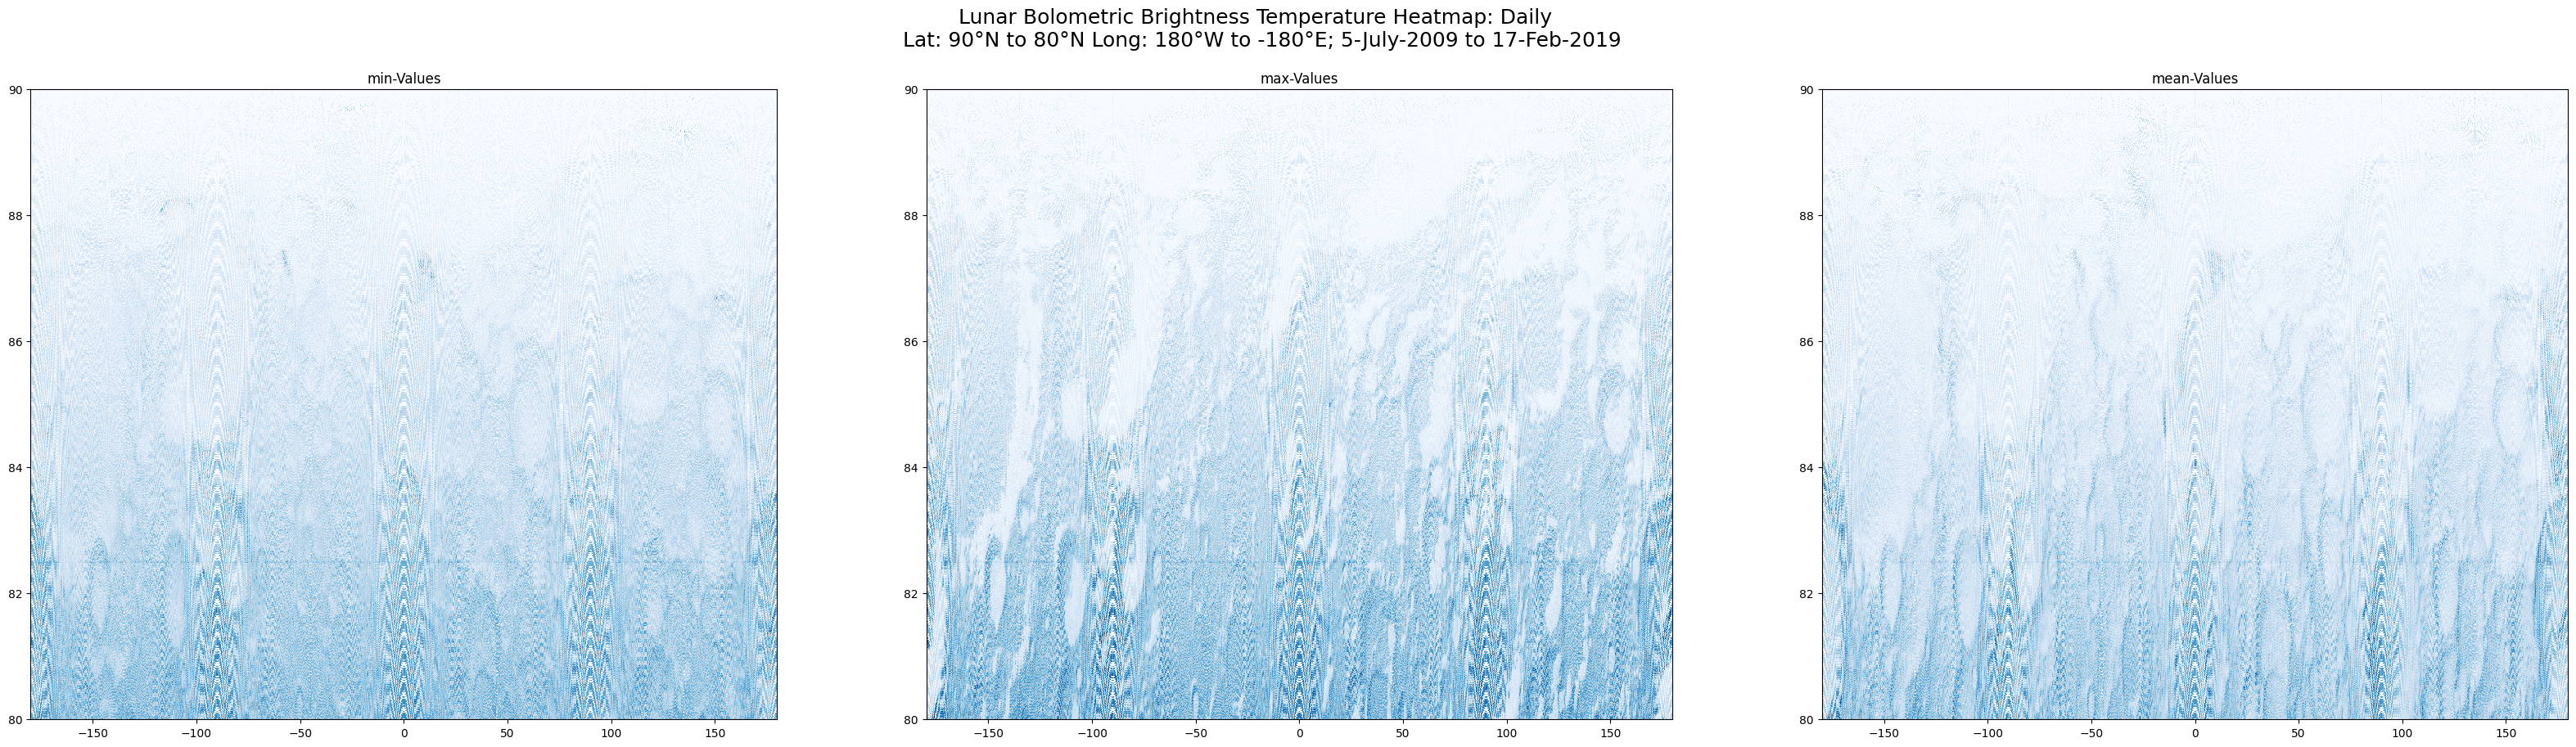

<Figure size 640x480 with 0 Axes>

In [ ]:
# Heat Map Visualization

fig, axs = plt.subplots(1, 3, figsize=(40, 10))

X = lunar_temp_data_analysed['        clon']
Y = lunar_temp_data_analysed['       clat']

for iteration, operation in enumerate(['min', 'max', 'mean']):
    
    w = lunar_temp_data_analysed['       tbol',  operation]

    axs[iteration].hist2d(X, Y, bins=heat_map_bins, cmap='Blues', weights=w)
    axs[iteration].set_title(f'{operation}-Values')

#plt.colorbar()
fig.suptitle(f'Lunar Bolometric Brightness Temperature Heatmap: Daily \n Lat: 90°N to 80°N Long: 180°W to -180°E; 5-July-2009 to 17-Feb-2019', fontsize=18, ha='center')
            
plt.show()
plt.savefig('../results/Lunar_tbol_Heatmap_t=daily.png')

In [ ]:
#data compression -> reducing computiational complexity

lunar_temp_data_analysed.to_hdf('../data/lunar_temp_data_analysed_compressed', key='data', mode='w', complevel=9, complib='blosc')
lunar_temp_data_analysed = pd.read_hdf('../data/lunar_temp_data_analysed_compressed', key='data')

In [ ]:
#Create Visualization with topographic map of the moon surface

fig, axs = plt.subplots(1, 3, figsize=(80, 20))

# Read the lunar topography image using Pillow
lunar_north_pole_img_original = Image.open('../data/6304h.tiff')

#convert lunar image into numpy array and get it into the right color format for further processing the image with libaries such as OpenCV
lunar_img_np = np.array(lunar_north_pole_img_original)
lunar_north_pole_img = cv2.cvtColor(lunar_img_np, cv2.COLOR_RGB2BGR)

#convert lunar north pole image into greyscale format to have a baseline map for choropleth map
lunar_north_pole_img_grey = cv2.cvtColor(lunar_north_pole_img, cv2.COLOR_RGB2GRAY)

#splitting the lunar_north_pole_image binarily into tha part with the black background and the coloured part
#all pixel colour values under 1 (-> near black values) get the value 0, the others get the value 255
#based on the number assignements all pixels with the value 255 are selected to create a mask, which is the part of the picture containing the satellite map, excluding the near-black background
#_ stores the threshold value and is not required anymore
#mask stores the relevant pixel positions 
_, mask = cv2.threshold(lunar_north_pole_img_grey, 1, 255, cv2.THRESH_BINARY)

#Find the center and radius of the North Pole region
#1. Get identified contours of the picture (outer lines of identied forms)
contours, _ = cv2.findContours(mask, 
                               cv2.RETR_EXTERNAL, #Taking only the extreme outer contours, because contour hierarchies are not relevant in this case
                               cv2.CHAIN_APPROX_SIMPLE #Removes redundant point and compreses data complexity
                               )

#2. Determine the maximum area enclosed by the contour using the max-function
contour_area = max( #determines the maximum elememnt in an iterable 
                   contours, #iterable = list of contours
                   key=cv2.contourArea #key to choose largest elements: cv2.contourArea which determines the area size enclosed by a contour
                   )

#3. Determine the minimum circle that encloses the contour_area and get center + radius
(x, y), radius = cv2.minEnclosingCircle(contour_area)

#performing the choropleth map creation for every operation (min, max, avg)
for iteration, operation in enumerate(['min', 'max', 'mean']):

    lunar_temp_data_analysed_iteration = lunar_temp_data_analysed[[('        clon',     ''),( '       clat',     ''),( '       tbol', operation)]].copy()

    #Normalization: The data must be normalized on a scale of 0-1 so that it can later be used to create a colormap
    #1. Normalization Approach: min-max-normalization
    #normalized_temps = (lunar_temp_data_analysed_iteration['       tbol',  operation] - np.min(lunar_temp_data_analysed_iteration['       tbol',  operation])) / (np.max(lunar_temp_data_analysed_iteration['       tbol',  operation]) - np.min(lunar_temp_data_analysed_iteration['       tbol',  operation]))

    #2. Normalization Approach: percentile normalization (Better choice because more resistent to outliers)
    p1 = np.percentile(lunar_temp_data_analysed_iteration['       tbol',  operation], 1)
    p99 = np.percentile(lunar_temp_data_analysed_iteration['       tbol',  operation], 99)
    normalized_temps = (lunar_temp_data_analysed_iteration['       tbol',  operation] - p1) / (p99 - p1)

    lunar_temp_data_analysed_iteration['       tbol', operation] = normalized_temps.copy()    

    #Bring data into a coordinate-grid
    temperature_grid = lunar_temp_data_analysed_iteration.pivot(index='       clat', columns='        clon', values=('       tbol', operation))
    temperature_grid = temperature_grid.fillna(normalized_temps.mean()).copy()

    #Polar coordinates (clats, clons) of the temperature data
    clats, clons = np.mgrid[80:90:(temperature_grid.shape[0] * 1j), -180:180:(temperature_grid.shape[1] * 1j)]

    #Convert the polar coordinates to Cartesian coordinates 
    radius_scaled = radius * (clats - 80) / 10 #calculated the scaled_radius by dividing the actual clat delta by the max clat delta
    cart_x = radius_scaled * np.cos(np.radians(clons)) + x #radians(clons) converts degrees to radians, by multyplining the radius_scaled by the cos of that radiant the x values can be determined 
                                                           #Imagine triangles in Cartesian coordinate system (one edge along the x-axis, one between the center and the pixel,...)
                                                           #The + x helps to set the centre to the centre of the lunar image 
    cart_y = radius_scaled * np.sin(np.radians(clons)) + y # "

    coords = np.array([cart_x.ravel(), cart_y.ravel()]).T #coordinates are each flattend into 1D arrays, mapped by their index and transposed to get in the right format

    #Data Interpolation to create a dataframe of the same size as the lunar image that contains the brightness values
    temperature_data_mapped = griddata( #griddata performs interpolation - estimating a value based on a set of known data points to, in this case, reduce the amount of data points
                                        coords, #coordinates of input data points
                                        temperature_grid.to_numpy().ravel(), #values of input data points
                                        (np.indices(lunar_north_pole_img.shape[:2])[1], np.indices(lunar_north_pole_img.shape[:2])[0]), #coordinates of the points where to interpolate -> using the pixels of the lunar image (:2, because cholor channels in 3rd index are not to be considered)
                                        method='cubic' #as a more complex interpolation method (alt: linear, nearest)
                                        )
    
    #Potential C-Maps
    colors = ['PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu', 'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic',
            'viridis', 'plasma', 'inferno', 'magma', 'cividis',
            'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn',
            'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink', 'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia', 'hot', 'afmhot', 'gist_heat', 'copper',
            'twilight', 'twilight_shifted', 'hsv',
            'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern', 'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg', 'gist_rainbow', 'rainbow', 'jet', 'turbo', 'nipy_spectral', 'gist_ncar']

    #Color the North Pole region based on the mapped temperature data
    for color in colors:
        color = 'rainbow'
        colormap = plt.get_cmap(f'{color}') #{color}')
        #colormap = sns.color_palette("viridis", as_cmap=True)
        #colormap = sns.color_palette("Spectral", as_cmap=True)
        #colormap = sns.color_palette("coolwarm", as_cmap=True)
        #colormap = sns.cubehelix_palette(start=0, rot=2, dark=0, light=1, as_cmap=True)

        colored_temps = colormap(temperature_data_mapped)

        #Apply the mask to only color the region of interest
        colored_roi = (colored_temps[:, :, :3] * 255 * (mask[:, :, np.newaxis] / 255)).astype(np.uint8) #the mask-normalization serves the purpose of turning the mask values (0&255) into 0 & 1s -> Multiplying this with the colored_temps "delets" all colors out of the region of interest
        colored_image = cv2.addWeighted(lunar_north_pole_img, 0.4, colored_roi, 0.6, 0) #laying the lunar image and the colors of the region of interests on top of each other 

        #Save the final image
        final_image = cv2.cvtColor(colored_image, cv2.COLOR_BGR2RGB)
        current_image = Image.fromarray(final_image)
        current_image.save(f'../results/Lunar_tbol_Choropleth_c={color}_op={operation}_t=daily.tiff')

    axs[iteration].imshow(current_image)
    axs[iteration].set_title(f'{operation}-Values')
    
p1 = np.percentile(lunar_temp_data_analysed['       tbol',  'mean'], 1)
p99 = np.percentile(lunar_temp_data_analysed['       tbol',  'mean'], 99)

#Create the Normalize object using the min and max percentiles
vmin = p1
vmax = p99
norm = Normalize(vmin=vmin, vmax=vmax)

#Create the ScalarMappable object
sm = ScalarMappable(cmap=colormap, norm=norm)

# Add a colorbar to the plot using the ScalarMappable object
fig.colorbar(sm, orientation='vertical', label='Temp')

fig.suptitle(f'Lunar Bolometric Brightness Temperature Choropleth: Daily \n Lat: 90°N to 80°N Long: 180°W to -180°E; 5-July-2009 to 17-Feb-2019', fontsize=38, ha='center')

plt.savefig('../results/Lunar_tbol_Choropleth_t=daily.png')

plt.show()

/var/folders/b7/d5n6chf90j3_1jm09jcg308h0000gn/T/ipykernel_3459/4145045824.py:55: PerformanceWarning: The following operation may generate 3557137545 cells in the resulting pandas object.
  temperature_grid = lunar_temp_data_analysed_iteration.pivot(index='       clat', columns='        clon', values=('       tbol', operation))


### Visualization: Feasibility Map

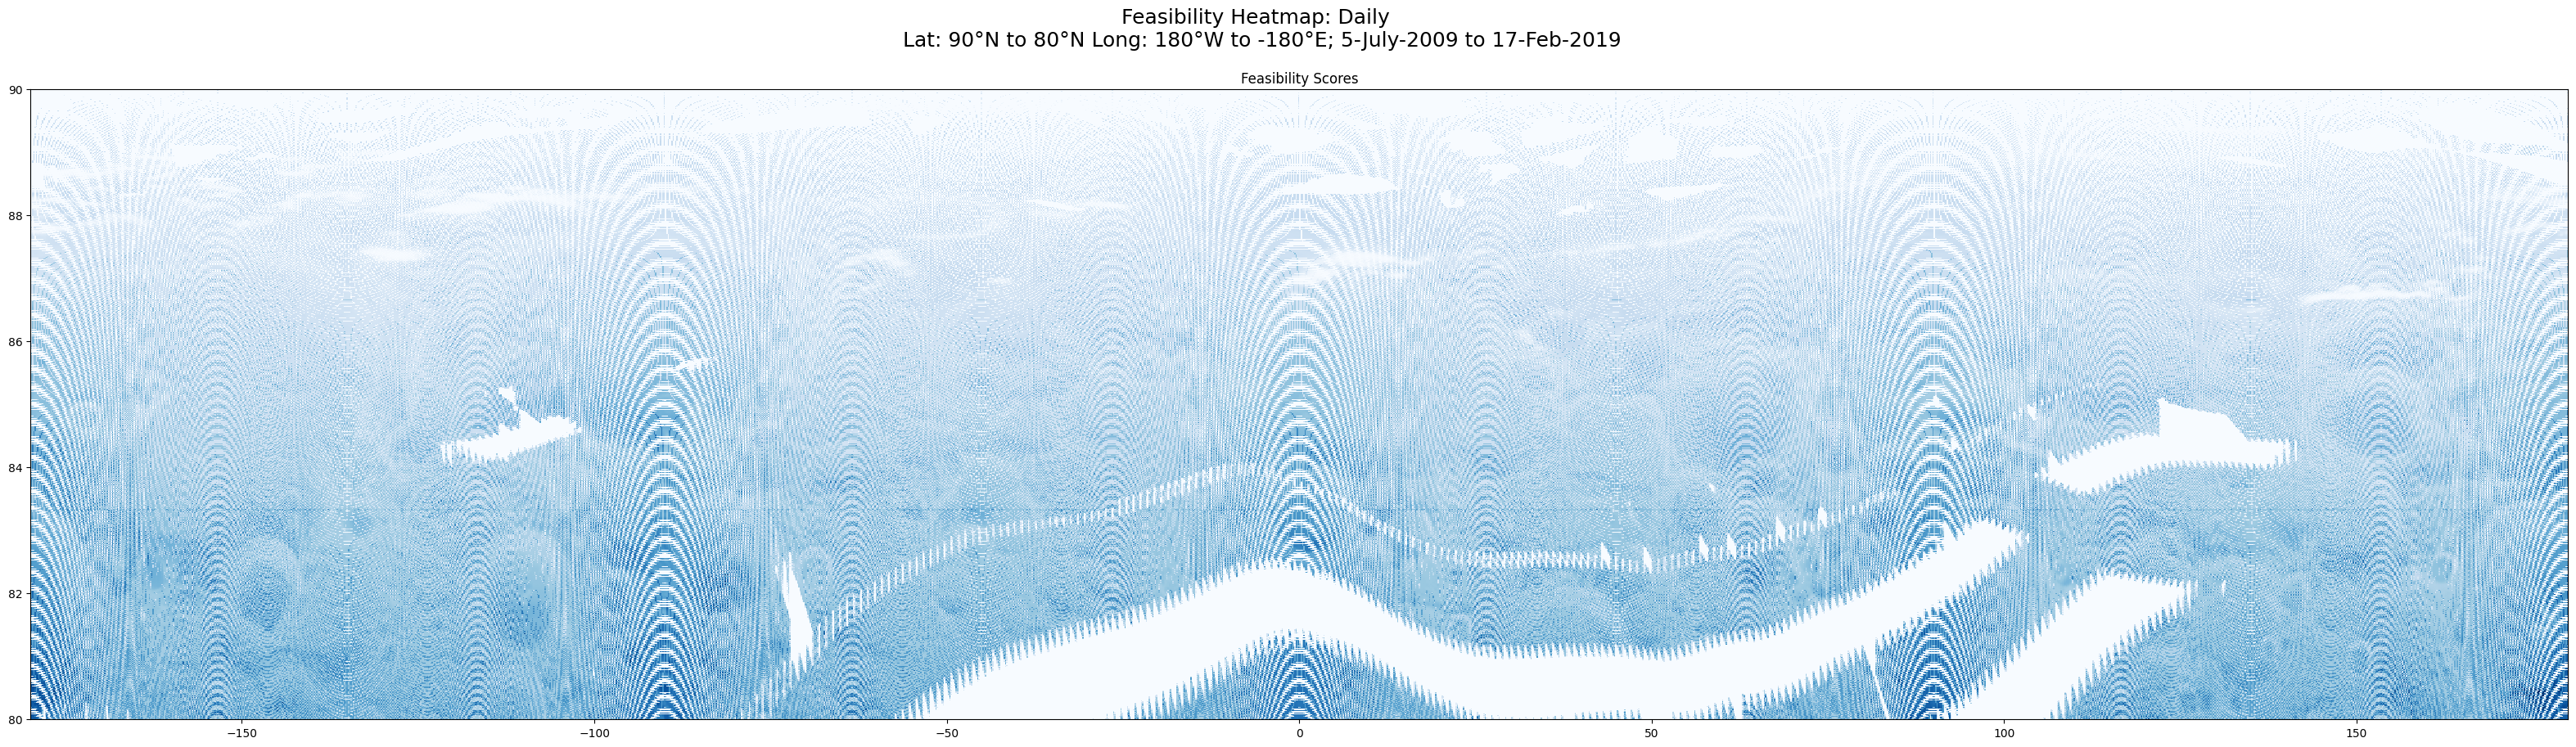

<Figure size 640x480 with 0 Axes>

In [ ]:
# Heat Map Visualization

fig, axs = plt.subplots(figsize=(40, 10))

X = lunar_temp_data_analysed['        clon']
Y = lunar_temp_data_analysed['       clat']

w = lunar_temp_data_analysed['feasibility_score']

axs.hist2d(X, Y, bins=heat_map_bins, cmap='Blues', weights=w)
axs.set_title(f'Feasibility Scores')

#plt.colorbar()
fig.suptitle(f'Feasibility Heatmap: Daily \n Lat: 90°N to 80°N Long: 180°W to -180°E; 5-July-2009 to 17-Feb-2019', fontsize=18, ha='center')
            
plt.show()
plt.savefig('../results/Lunar_Feasibility_Heatmap_t=daily.png')

In [ ]:
#data compression -> reducing computiational complexity

lunar_temp_data_analysed.to_hdf('../data/lunar_temp_data_analysed_compressed', key='data', mode='w', complevel=9, complib='blosc')
lunar_temp_data_analysed = pd.read_hdf('../data/lunar_temp_data_analysed_compressed', key='data')

In [ ]:
#Create Visualization with topographic map of the moon surface

fig, axs = plt.subplots(1, 3, figsize=(80, 20))

# Read the lunar topography image using Pillow
lunar_north_pole_img_original = Image.open('../data/6304h.tiff')

#convert lunar image into numpy array and get it into the right color format for further processing the image with libaries such as OpenCV
lunar_img_np = np.array(lunar_north_pole_img_original)
lunar_north_pole_img = cv2.cvtColor(lunar_img_np, cv2.COLOR_RGB2BGR)

#convert lunar north pole image into greyscale format to have a baseline map for choropleth map
lunar_north_pole_img_grey = cv2.cvtColor(lunar_north_pole_img, cv2.COLOR_RGB2GRAY)

#splitting the lunar_north_pole_image binarily into tha part with the black background and the coloured part
#all pixel colour values under 1 (-> near black values) get the value 0, the others get the value 255
#based on the number assignements all pixels with the value 255 are selected to create a mask, which is the part of the picture containing the satellite map, excluding the near-black background
#_ stores the threshold value and is not required anymore
#mask stores the relevant pixel positions 
_, mask = cv2.threshold(lunar_north_pole_img_grey, 1, 255, cv2.THRESH_BINARY)

#Find the center and radius of the North Pole region
#1. Get identified contours of the picture (outer lines of identied forms)
contours, _ = cv2.findContours(mask, 
                               cv2.RETR_EXTERNAL, #Taking only the extreme outer contours, because contour hierarchies are not relevant in this case
                               cv2.CHAIN_APPROX_SIMPLE #Removes redundant point and compreses data complexity
                               )

#2. Determine the maximum area enclosed by the contour using the max-function
contour_area = max( #determines the maximum elememnt in an iterable 
                   contours, #iterable = list of contours
                   key=cv2.contourArea #key to choose largest elements: cv2.contourArea which determines the area size enclosed by a contour
                   )

#3. Determine the minimum circle that encloses the contour_area and get center + radius
(x, y), radius = cv2.minEnclosingCircle(contour_area)


lunar_temp_data_analysed

#Normalization: The data must be normalized on a scale of 0-1 so that it can later be used to create a colormap
#1. Normalization Approach: min-max-normalization
#normalized_temps = (lunar_temp_data_analysed_iteration['       tbol',  operation] - np.min(lunar_temp_data_analysed_iteration['       tbol',  operation])) / (np.max(lunar_temp_data_analysed_iteration['       tbol',  operation]) - np.min(lunar_temp_data_analysed_iteration['       tbol',  operation]))

#2. Normalization Approach: percentile normalization (Better choice because more resistent to outliers)
p1 = np.percentile(lunar_temp_data_analysed_iteration['feasibility_score'], 1)
p99 = np.percentile(lunar_temp_data_analysed_iteration['feasibility_score'], 99)
normalized_temps = (lunar_temp_data_analysed_iteration['feasibility_score'] - p1) / (p99 - p1)

lunar_temp_data_analysed_iteration['feasibility_score'] = normalized_temps.copy()    

#Bring data into a coordinate-grid
temperature_grid = lunar_temp_data_analysed_iteration.pivot(index='       clat', columns='        clon', values=('feasibility_score'))
temperature_grid = temperature_grid.fillna(normalized_temps.mean()).copy()

#Polar coordinates (clats, clons) of the temperature data
clats, clons = np.mgrid[80:90:(temperature_grid.shape[0] * 1j), -180:180:(temperature_grid.shape[1] * 1j)]

#Convert the polar coordinates to Cartesian coordinates 
radius_scaled = radius * (clats - 80) / 10 #calculated the scaled_radius by dividing the actual clat delta by the max clat delta
cart_x = radius_scaled * np.cos(np.radians(clons)) + x #radians(clons) converts degrees to radians, by multyplining the radius_scaled by the cos of that radiant the x values can be determined 
                                                           #Imagine triangles in Cartesian coordinate system (one edge along the x-axis, one between the center and the pixel,...)
                                                           #The + x helps to set the centre to the centre of the lunar image 
cart_y = radius_scaled * np.sin(np.radians(clons)) + y # "

coords = np.array([cart_x.ravel(), cart_y.ravel()]).T #coordinates are each flattend into 1D arrays, mapped by their index and transposed to get in the right format

    #Data Interpolation to create a dataframe of the same size as the lunar image that contains the brightness values
temperature_data_mapped = griddata( #griddata performs interpolation - estimating a value based on a set of known data points to, in this case, reduce the amount of data points
                                        coords, #coordinates of input data points
                                        temperature_grid.to_numpy().ravel(), #values of input data points
                                        (np.indices(lunar_north_pole_img.shape[:2])[1], np.indices(lunar_north_pole_img.shape[:2])[0]), #coordinates of the points where to interpolate -> using the pixels of the lunar image (:2, because cholor channels in 3rd index are not to be considered)
                                        method='cubic' #as a more complex interpolation method (alt: linear, nearest)
                                        )
    
    #Potential C-Maps
colors = ['PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu', 'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic',
            'viridis', 'plasma', 'inferno', 'magma', 'cividis',
            'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn',
            'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink', 'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia', 'hot', 'afmhot', 'gist_heat', 'copper',
            'twilight', 'twilight_shifted', 'hsv',
            'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern', 'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg', 'gist_rainbow', 'rainbow', 'jet', 'turbo', 'nipy_spectral', 'gist_ncar']

    #Color the North Pole region based on the mapped temperature data
for color in colors:
    color = 'rainbow'
    colormap = plt.get_cmap(f'{color}') #{color}')
        #colormap = sns.color_palette("viridis", as_cmap=True)
        #colormap = sns.color_palette("Spectral", as_cmap=True)
        #colormap = sns.color_palette("coolwarm", as_cmap=True)
        #colormap = sns.cubehelix_palette(start=0, rot=2, dark=0, light=1, as_cmap=True)

    colored_temps = colormap(temperature_data_mapped)

        #Apply the mask to only color the region of interest
    colored_roi = (colored_temps[:, :, :3] * 255 * (mask[:, :, np.newaxis] / 255)).astype(np.uint8) #the mask-normalization serves the purpose of turning the mask values (0&255) into 0 & 1s -> Multiplying this with the colored_temps "delets" all colors out of the region of interest
    colored_image = cv2.addWeighted(lunar_north_pole_img, 0.4, colored_roi, 0.6, 0) #laying the lunar image and the colors of the region of interests on top of each other 

        #Save the final image
    final_image = cv2.cvtColor(colored_image, cv2.COLOR_BGR2RGB)
    current_image = Image.fromarray(final_image)
    current_image.save(f'../results/Lunar_Feasibility_Choropleth_c={color}_t=daily.tiff')

axs.imshow(current_image)
axs.set_title(f'Feasibility Score')
    
p1 = np.percentile(lunar_temp_data_analysed['feasibility_score'], 1)
p99 = np.percentile(lunar_temp_data_analysed['feasibility_score'], 99)

#Create the Normalize object using the min and max percentiles
vmin = p1
vmax = p99
norm = Normalize(vmin=vmin, vmax=vmax)

#Create the ScalarMappable object
sm = ScalarMappable(cmap=colormap, norm=norm)

# Add a colorbar to the plot using the ScalarMappable object
fig.colorbar(sm, orientation='vertical', label='Temp')

fig.suptitle(f'Lunar Feasibility Score Choropleth: Daily \n Lat: 90°N to 80°N Long: 180°W to -180°E; 5-July-2009 to 17-Feb-2019', fontsize=38, ha='center')

plt.savefig('../results/Lunar_Feasibility_Choropleth_t=daily.png')

plt.show()

/var/folders/1m/_421zvqd2kj8wnbn64qd_w4m0000gn/T/ipykernel_2886/4145045824.py:55: PerformanceWarning: The following operation may generate 3551420048 cells in the resulting pandas object.
  temperature_grid = lunar_temp_data_analysed_iteration.pivot(index='       clat', columns='        clon', values=('       tbol', operation))


: 

: 

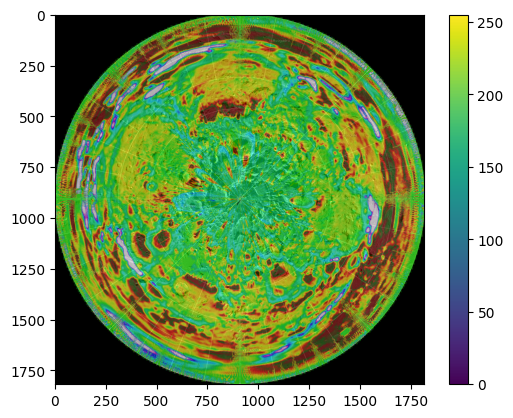

In [ ]:
fig, ax = plt.subplots()
plt.imshow(current_image)
plt.colorbar()
plt.show()